In [1]:
library(tidyverse)
library(tidymodels)
library(repr)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

-- Attaching packages ------------------------------------------------------------------------------ tidymodels 0.1.3 --

v broom        0.7.6      v rsample      0.1.0 
v dials        0.0.9      v tune         0.1.5 
v infer        0.5.4      v workflows    0.2.2 
v modeldata    0.1.0      v workflowsets 0.0.2 
v parsnip      0.1.6      v yardstick    0.0.8 
v recipes      0.1.16     

-- Conflicts ----------------

In [2]:
data <- read_csv("heart.csv")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trtbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalachh = col_double(),
  exng = col_double(),
  oldpeak = col_double(),
  slp = col_double(),
  caa = col_double(),
  thall = col_double(),
  output = col_double()
)




In [3]:
head(data)

age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1


In [4]:
str(data)

spec_tbl_df [303 x 14] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ age     : num [1:303] 63 37 41 56 57 57 56 44 52 57 ...
 $ sex     : num [1:303] 1 1 0 1 0 1 0 1 1 1 ...
 $ cp      : num [1:303] 3 2 1 1 0 0 1 1 2 2 ...
 $ trtbps  : num [1:303] 145 130 130 120 120 140 140 120 172 150 ...
 $ chol    : num [1:303] 233 250 204 236 354 192 294 263 199 168 ...
 $ fbs     : num [1:303] 1 0 0 0 0 0 0 0 1 0 ...
 $ restecg : num [1:303] 0 1 0 1 1 1 0 1 1 1 ...
 $ thalachh: num [1:303] 150 187 172 178 163 148 153 173 162 174 ...
 $ exng    : num [1:303] 0 0 0 0 1 0 0 0 0 0 ...
 $ oldpeak : num [1:303] 2.3 3.5 1.4 0.8 0.6 0.4 1.3 0 0.5 1.6 ...
 $ slp     : num [1:303] 0 0 2 2 2 1 1 2 2 2 ...
 $ caa     : num [1:303] 0 0 0 0 0 0 0 0 0 0 ...
 $ thall   : num [1:303] 1 2 2 2 2 1 2 3 3 2 ...
 $ output  : num [1:303] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "spec")=
  .. cols(
  ..   age = col_double(),
  ..   sex = col_double(),
  ..   cp = col_double(),
  ..   trtbps = col_double(),
  ..   chol = col_doub

In [5]:
# editing data, adding categorical labels and factors for feature engineering
data_formatted <- data %>%
    mutate(sex = ifelse(sex == 0, "M", "F"), sex = factor(sex)) %>%
    mutate(exng = ifelse(exng == 0, "N", "Y"), exng = factor(exng)) %>%
    mutate(cp = factor(cp)) %>%
    mutate(fbs = ifelse(fbs == 0, "N", "Y"), fbs = factor(fbs)) %>%
    mutate(restecg = factor(restecg)) %>%
    rename(heart_attack = output) %>%
    mutate(heart_attack = ifelse(heart_attack == 0, "N", "Y"), heart_attack = factor(heart_attack, levels = c("Y", "N"))) %>%
    mutate(slp = factor(slp)) %>%
    mutate(caa = factor(caa)) %>%
    mutate(thall = factor(thall))

head(data_formatted)

age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,heart_attack
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,F,3,145,233,Y,0,150,N,2.3,0,0,1,Y
37,F,2,130,250,N,1,187,N,3.5,0,0,2,Y
41,M,1,130,204,N,0,172,N,1.4,2,0,2,Y
56,F,1,120,236,N,1,178,N,0.8,2,0,2,Y
57,M,0,120,354,N,1,163,Y,0.6,2,0,2,Y
57,F,0,140,192,N,1,148,N,0.4,1,0,1,Y


Note that the `heart_attack` column was set to either `Y` or `N` columns. For this dataset, this column indicates whether there is either less or more likelihood of a heart attack, not that a heart attack was confirmed definitively. 

# Exploratory Data Analysis

First thing to check, is the sample population diverse with regards to sex, age, and likelihood of a heart attack?

In [6]:
data_formatted %>%
    count(sex)

sex,n
<fct>,<int>
F,207
M,96


In [7]:
# neat count() trick from: https://www.youtube.com/watch?v=NDHSBUN_rVU&t=389s, at 5:33
data_formatted %>%
    count(age_range = 10 * (age %/% 10), sort = TRUE)

age_range,n
<dbl>,<int>
50,125
60,80
40,72
30,15
70,10
20,1


In [8]:
data_formatted %>%
    count(heart_attack)

heart_attack,n
<fct>,<int>
Y,165
N,138


Conclusions: There are around 2 females to each male in this dataset. The ages of the people in this dataset skew towards older individuals which makes sense when talking about heart attacks. The heart attack likelihood is also decently equal, there is not much of a skew.

Next, what quantitative predictors most correlate to a high likelihood of a heart attack?

In [9]:
data_corr <- data_formatted %>%
    relocate(heart_attack) %>%
    mutate(heart_attack = ifelse(heart_attack == "N", 0, 1), heart_attack = as.numeric(heart_attack)) %>%
    select_if(is.numeric) %>%
    cor()

print(data_corr[1,])

heart_attack          age       trtbps         chol     thalachh      oldpeak 
  1.00000000  -0.22543872  -0.14493113  -0.08523911   0.42174093  -0.43069600 


As can be seen, the highest correlations are the the maximum heart rate `thalachh`, which is positively correlated, and `oldpeak`, which is negatively correlated. 

Next, is there a significant difference between the measurements of males and females?

In [10]:
data_tidy_quantitative <- data_formatted %>%
    mutate(id = row_number()) %>%
    relocate(id, sex, heart_attack) %>%
    select(id, sex, heart_attack, age, trtbps, chol, thalachh, oldpeak) %>%
    gather(variable, value, age:oldpeak) %>%
    arrange(id)

head(data_tidy_quantitative)

id,sex,heart_attack,variable,value
<int>,<fct>,<fct>,<chr>,<dbl>
1,F,Y,age,63.0
1,F,Y,trtbps,145.0
1,F,Y,chol,233.0
1,F,Y,thalachh,150.0
1,F,Y,oldpeak,2.3
2,F,Y,age,37.0


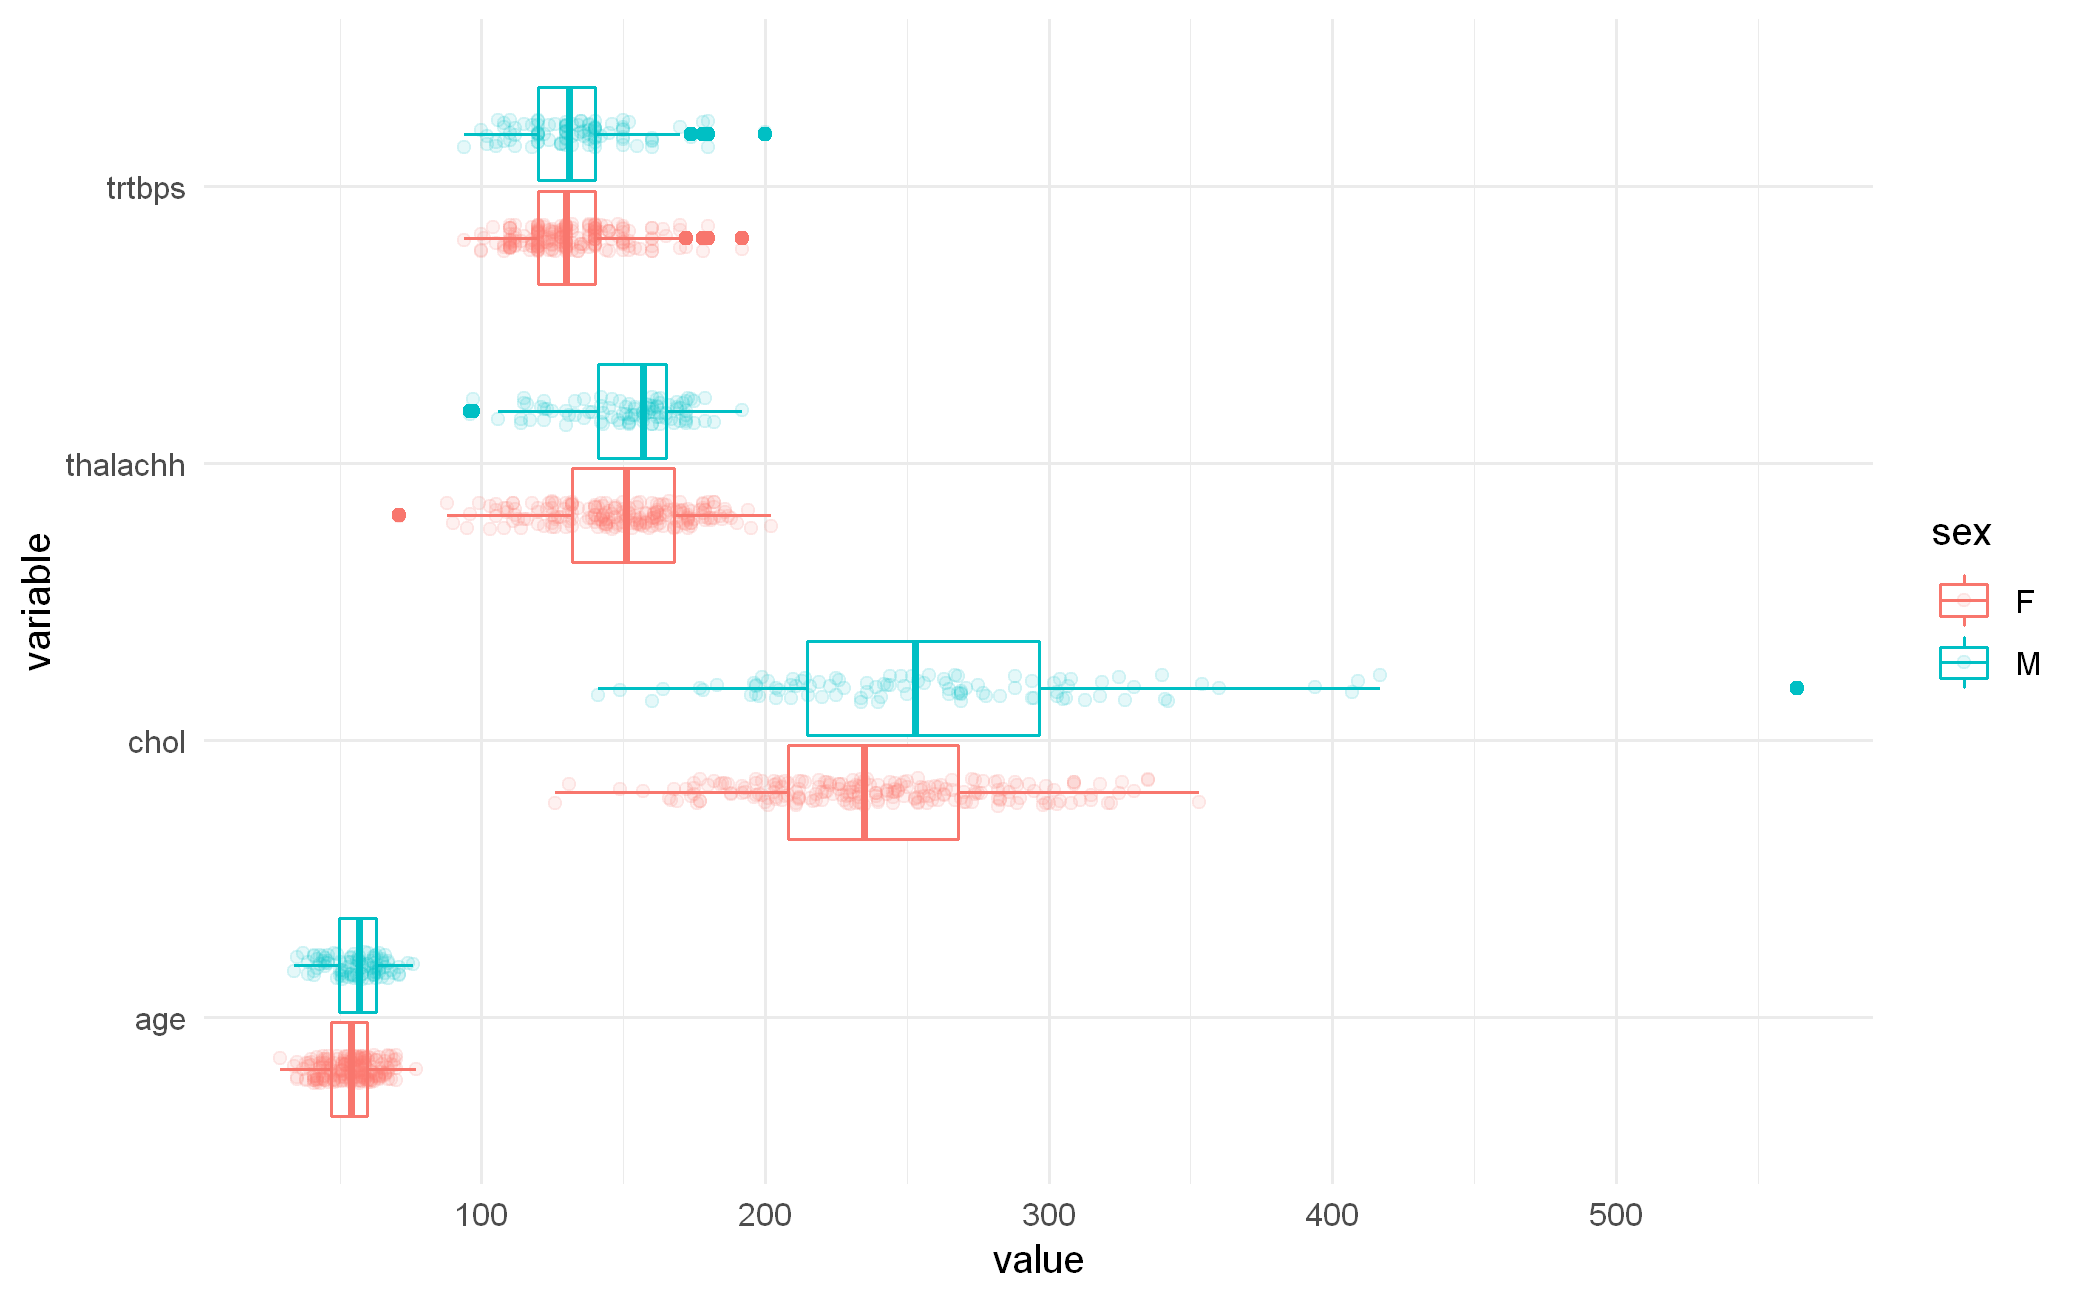

In [11]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=260)

# filtering out oldpeak, too small to see in plot
data_tidy_quantitative %>%
    filter(variable != "oldpeak") %>%
    ggplot(aes(variable, value, color = sex)) +
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        coord_flip()

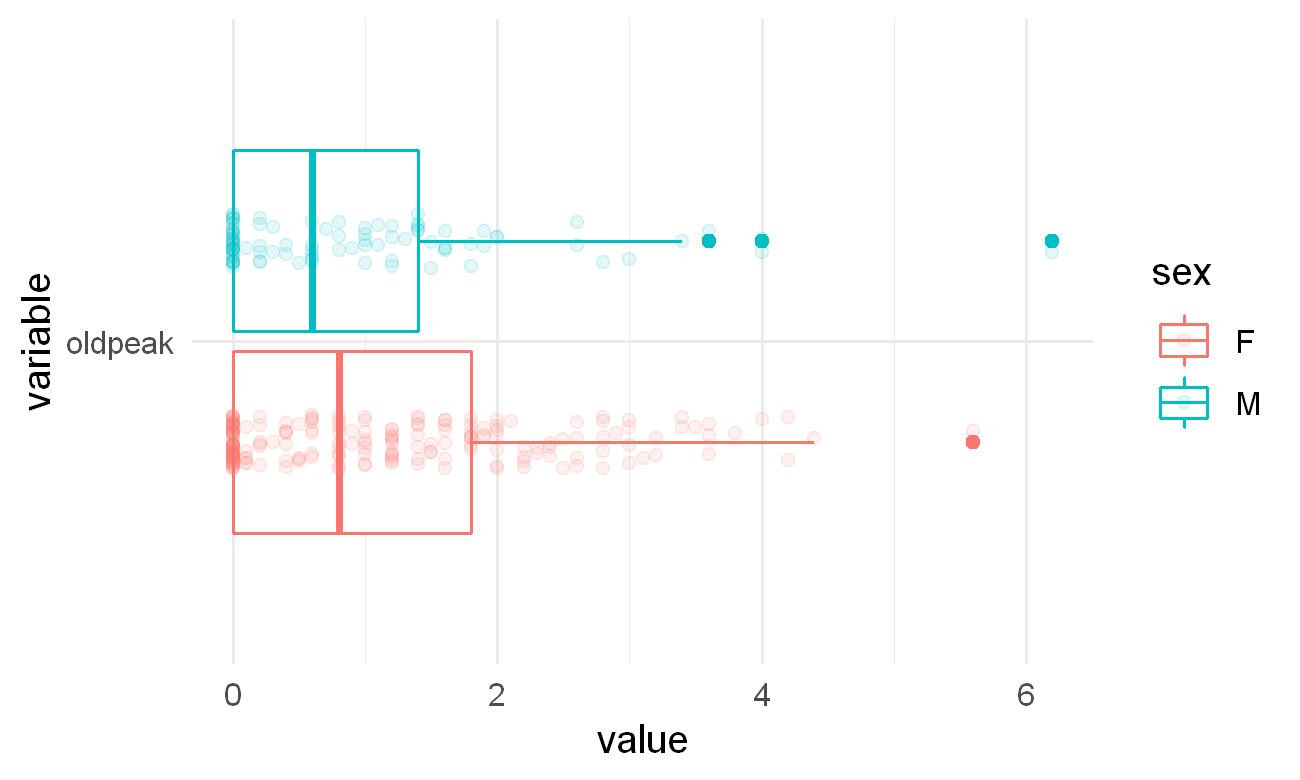

In [12]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res=260)
data_tidy_quantitative %>%
    filter(variable == "oldpeak") %>%
    ggplot(aes(variable, value, color = sex)) +
        geom_boxplot() + 
        geom_point(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.1) + 
        theme_minimal() +
        coord_flip()

As can be seen, there are some minor differences between males and females.

# Modeling

In [13]:
# splitting data
set.seed(22012000)

data_split <- initial_split(data_formatted)

data_train <- training(data_split)
data_test <- testing(data_split)

In [14]:
# preprocessing: center, scale, and one-hot encoding
preprocess_recipe <- recipe(heart_attack ~ ., data = data_train) %>%
    step_center(all_predictors(), -all_nominal()) %>%
    step_scale(all_predictors(), -all_nominal()) %>%
    step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE)

prepped_recipe <- prep(preprocess_recipe)

processed_data_train <- juice(prepped_recipe)

head(processed_data_train)

age,trtbps,chol,thalachh,oldpeak,heart_attack,sex_F,sex_M,cp_X0,cp_X1,...,slp_X2,caa_X0,caa_X1,caa_X2,caa_X3,caa_X4,thall_X0,thall_X1,thall_X2,thall_X3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.2964876,1.7249479,0.008937491,-1.34631147,-0.8851082,N,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
0.9651900,0.1965983,0.120615137,0.97400691,-0.8851082,Y,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
-1.5747581,0.5022682,-0.865870730,1.24173596,0.3622860,Y,1,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1.1860550,1.7249479,2.130812751,0.03695526,-0.1723115,Y,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
0.1921623,-0.7204115,-0.102740154,0.84014239,-0.8851082,Y,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
0.4130274,-0.2313396,0.250905723,-0.90009640,1.7878793,N,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [15]:
data_folds <- vfold_cv(data_train, v = 10, strata = heart_attack)

In [16]:
# specify model
rf_model <- rand_forest(mtry = tune(), trees = 500, min_n = tune()) %>%
    set_mode("classification") %>%
    set_engine("randomForest")

# specify modeling procedure
rf_workflow <- workflow() %>%
    add_recipe(preprocess_recipe) %>%
    add_model(rf_model)

# tuning model
model_results <- tune_grid(rf_workflow, resamples = data_folds, grid = 5, control = control_grid(save_pred = TRUE))

i Creating pre-processing data to finalize unknown parameter: mtry



In [17]:
collect_metrics(model_results)

mtry,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,23,accuracy,binary,0.8328063,10,0.02474209,Preprocessor1_Model1
12,23,roc_auc,binary,0.8938462,10,0.01797845,Preprocessor1_Model1
17,32,accuracy,binary,0.8104743,10,0.02516167,Preprocessor1_Model2
17,32,roc_auc,binary,0.8815812,10,0.02083851,Preprocessor1_Model2
24,6,accuracy,binary,0.8237154,10,0.01868794,Preprocessor1_Model3
24,6,roc_auc,binary,0.8839744,10,0.01872136,Preprocessor1_Model3
24,12,accuracy,binary,0.8328063,10,0.01813498,Preprocessor1_Model4
24,12,roc_auc,binary,0.8865385,10,0.02009701,Preprocessor1_Model4
2,34,accuracy,binary,0.8640316,10,0.01745358,Preprocessor1_Model5


In [18]:
show_best(model_results, metric = "roc_auc")

mtry,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,34,roc_auc,binary,0.9058974,10,0.01885405,Preprocessor1_Model5
12,23,roc_auc,binary,0.8938462,10,0.01797845,Preprocessor1_Model1
24,12,roc_auc,binary,0.8865385,10,0.02009701,Preprocessor1_Model4
24,6,roc_auc,binary,0.8839744,10,0.01872136,Preprocessor1_Model3
17,32,roc_auc,binary,0.8815812,10,0.02083851,Preprocessor1_Model2


In [19]:
show_best(model_results, metric = "accuracy")

mtry,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,34,accuracy,binary,0.8640316,10,0.01745358,Preprocessor1_Model5
12,23,accuracy,binary,0.8328063,10,0.02474209,Preprocessor1_Model1
24,12,accuracy,binary,0.8328063,10,0.01813498,Preprocessor1_Model4
24,6,accuracy,binary,0.8237154,10,0.01868794,Preprocessor1_Model3
17,32,accuracy,binary,0.8104743,10,0.02516167,Preprocessor1_Model2


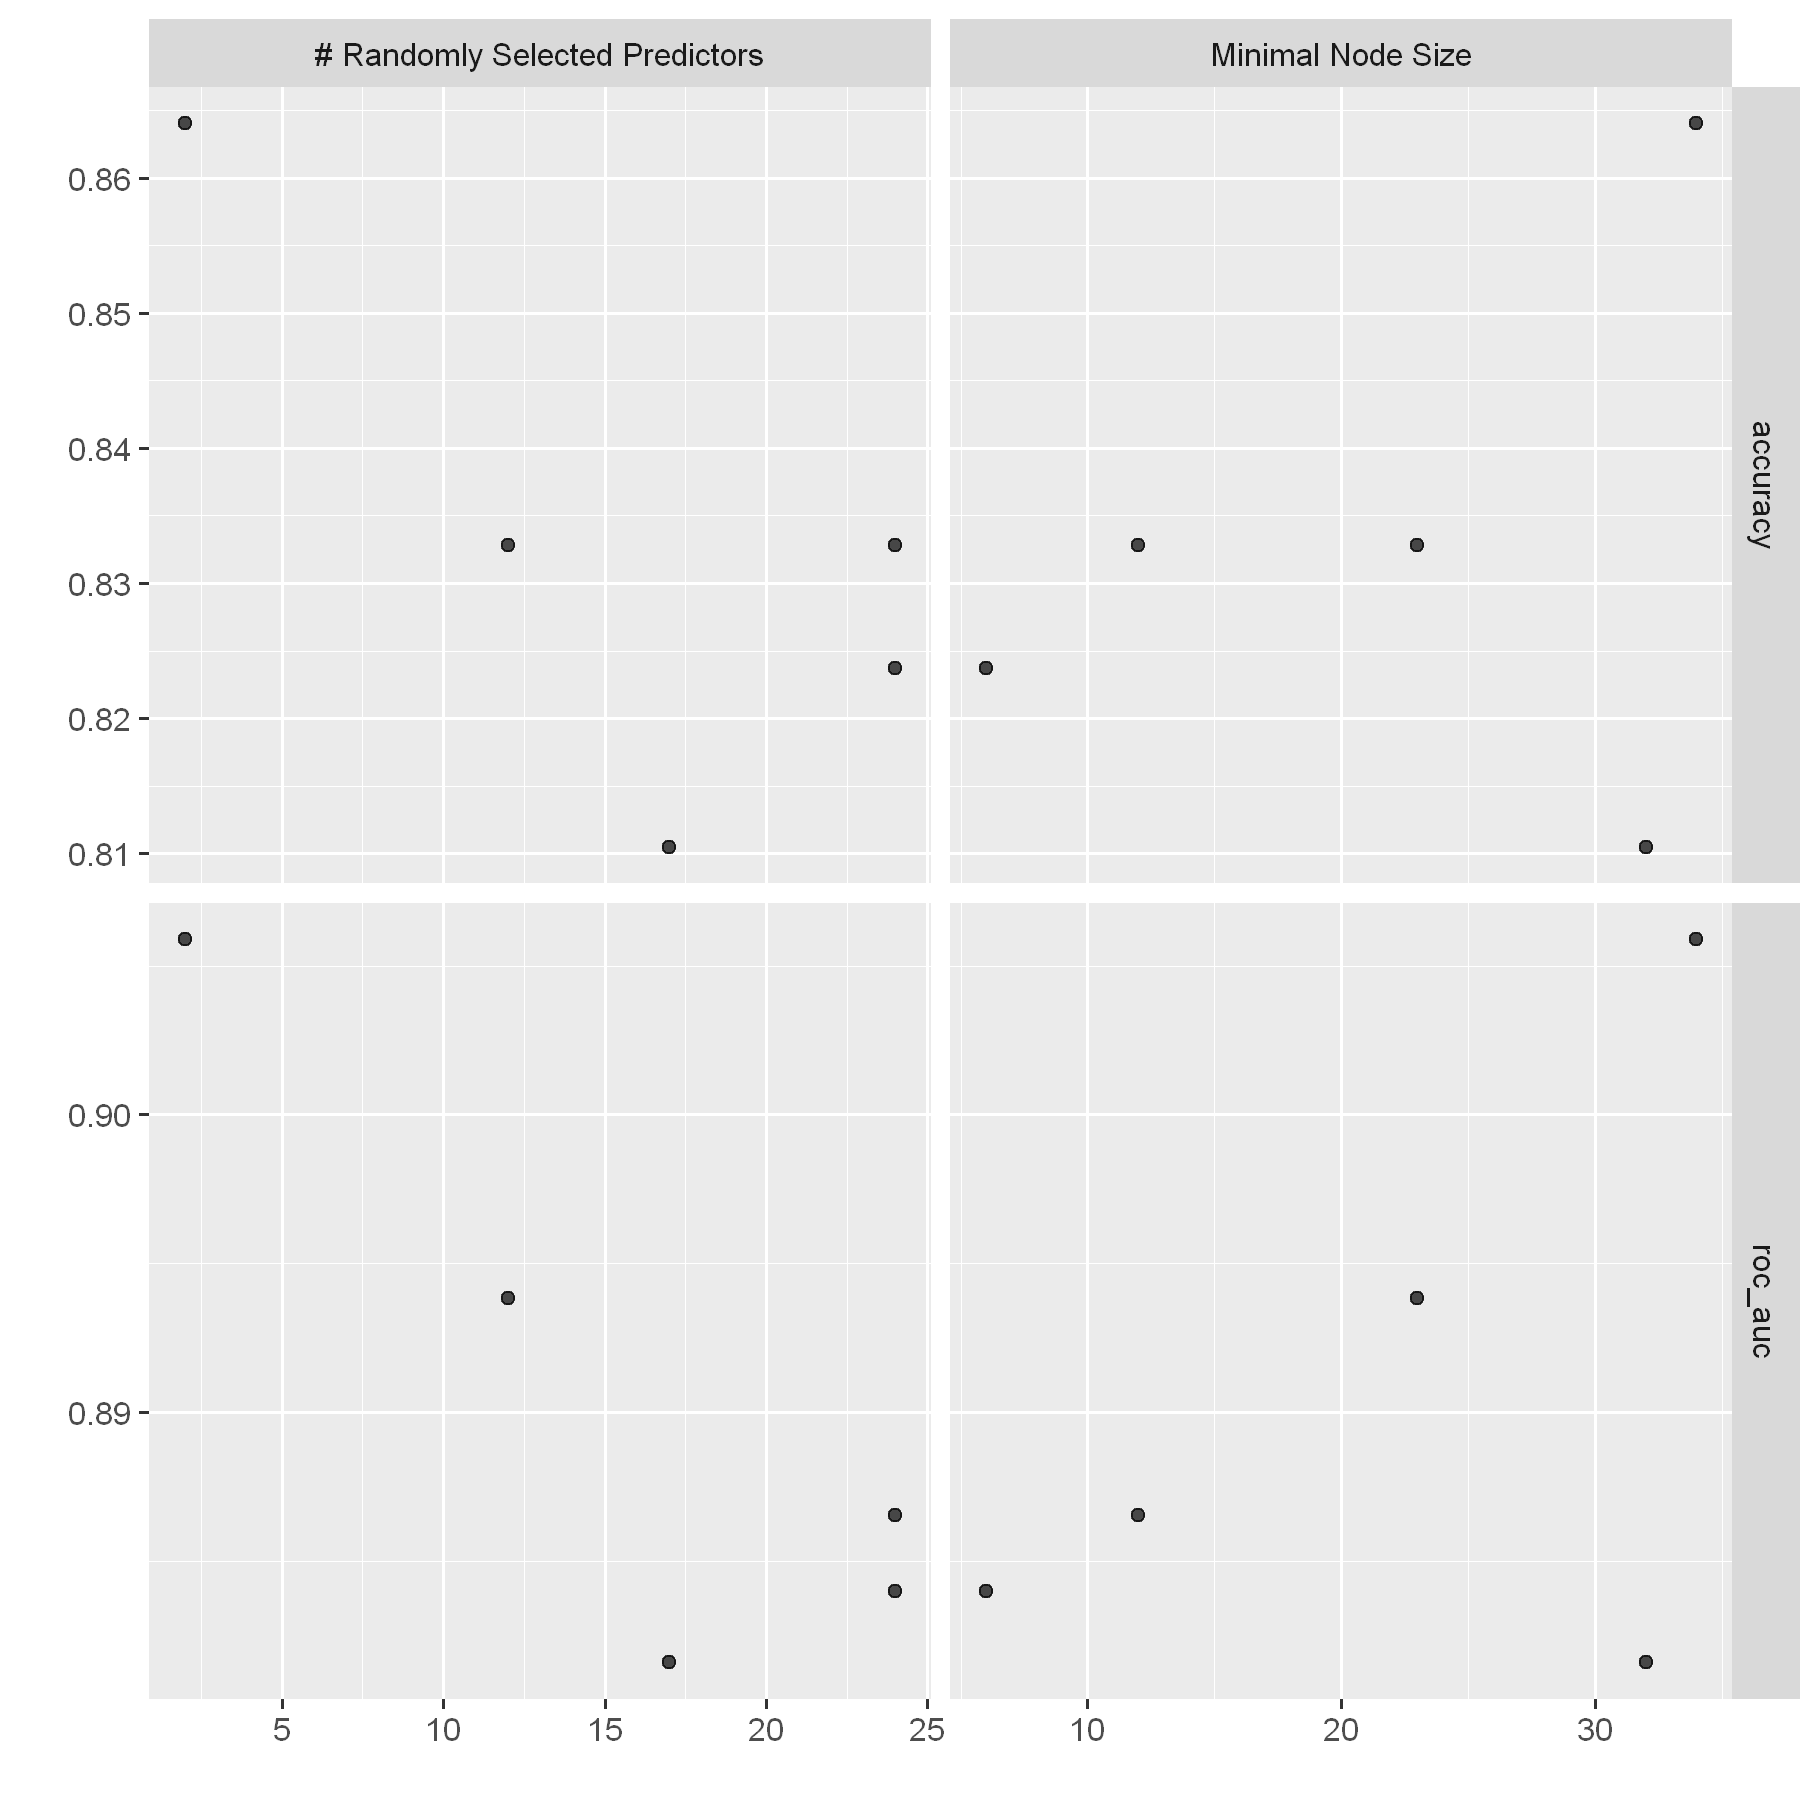

In [20]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res=260)
autoplot(model_results)

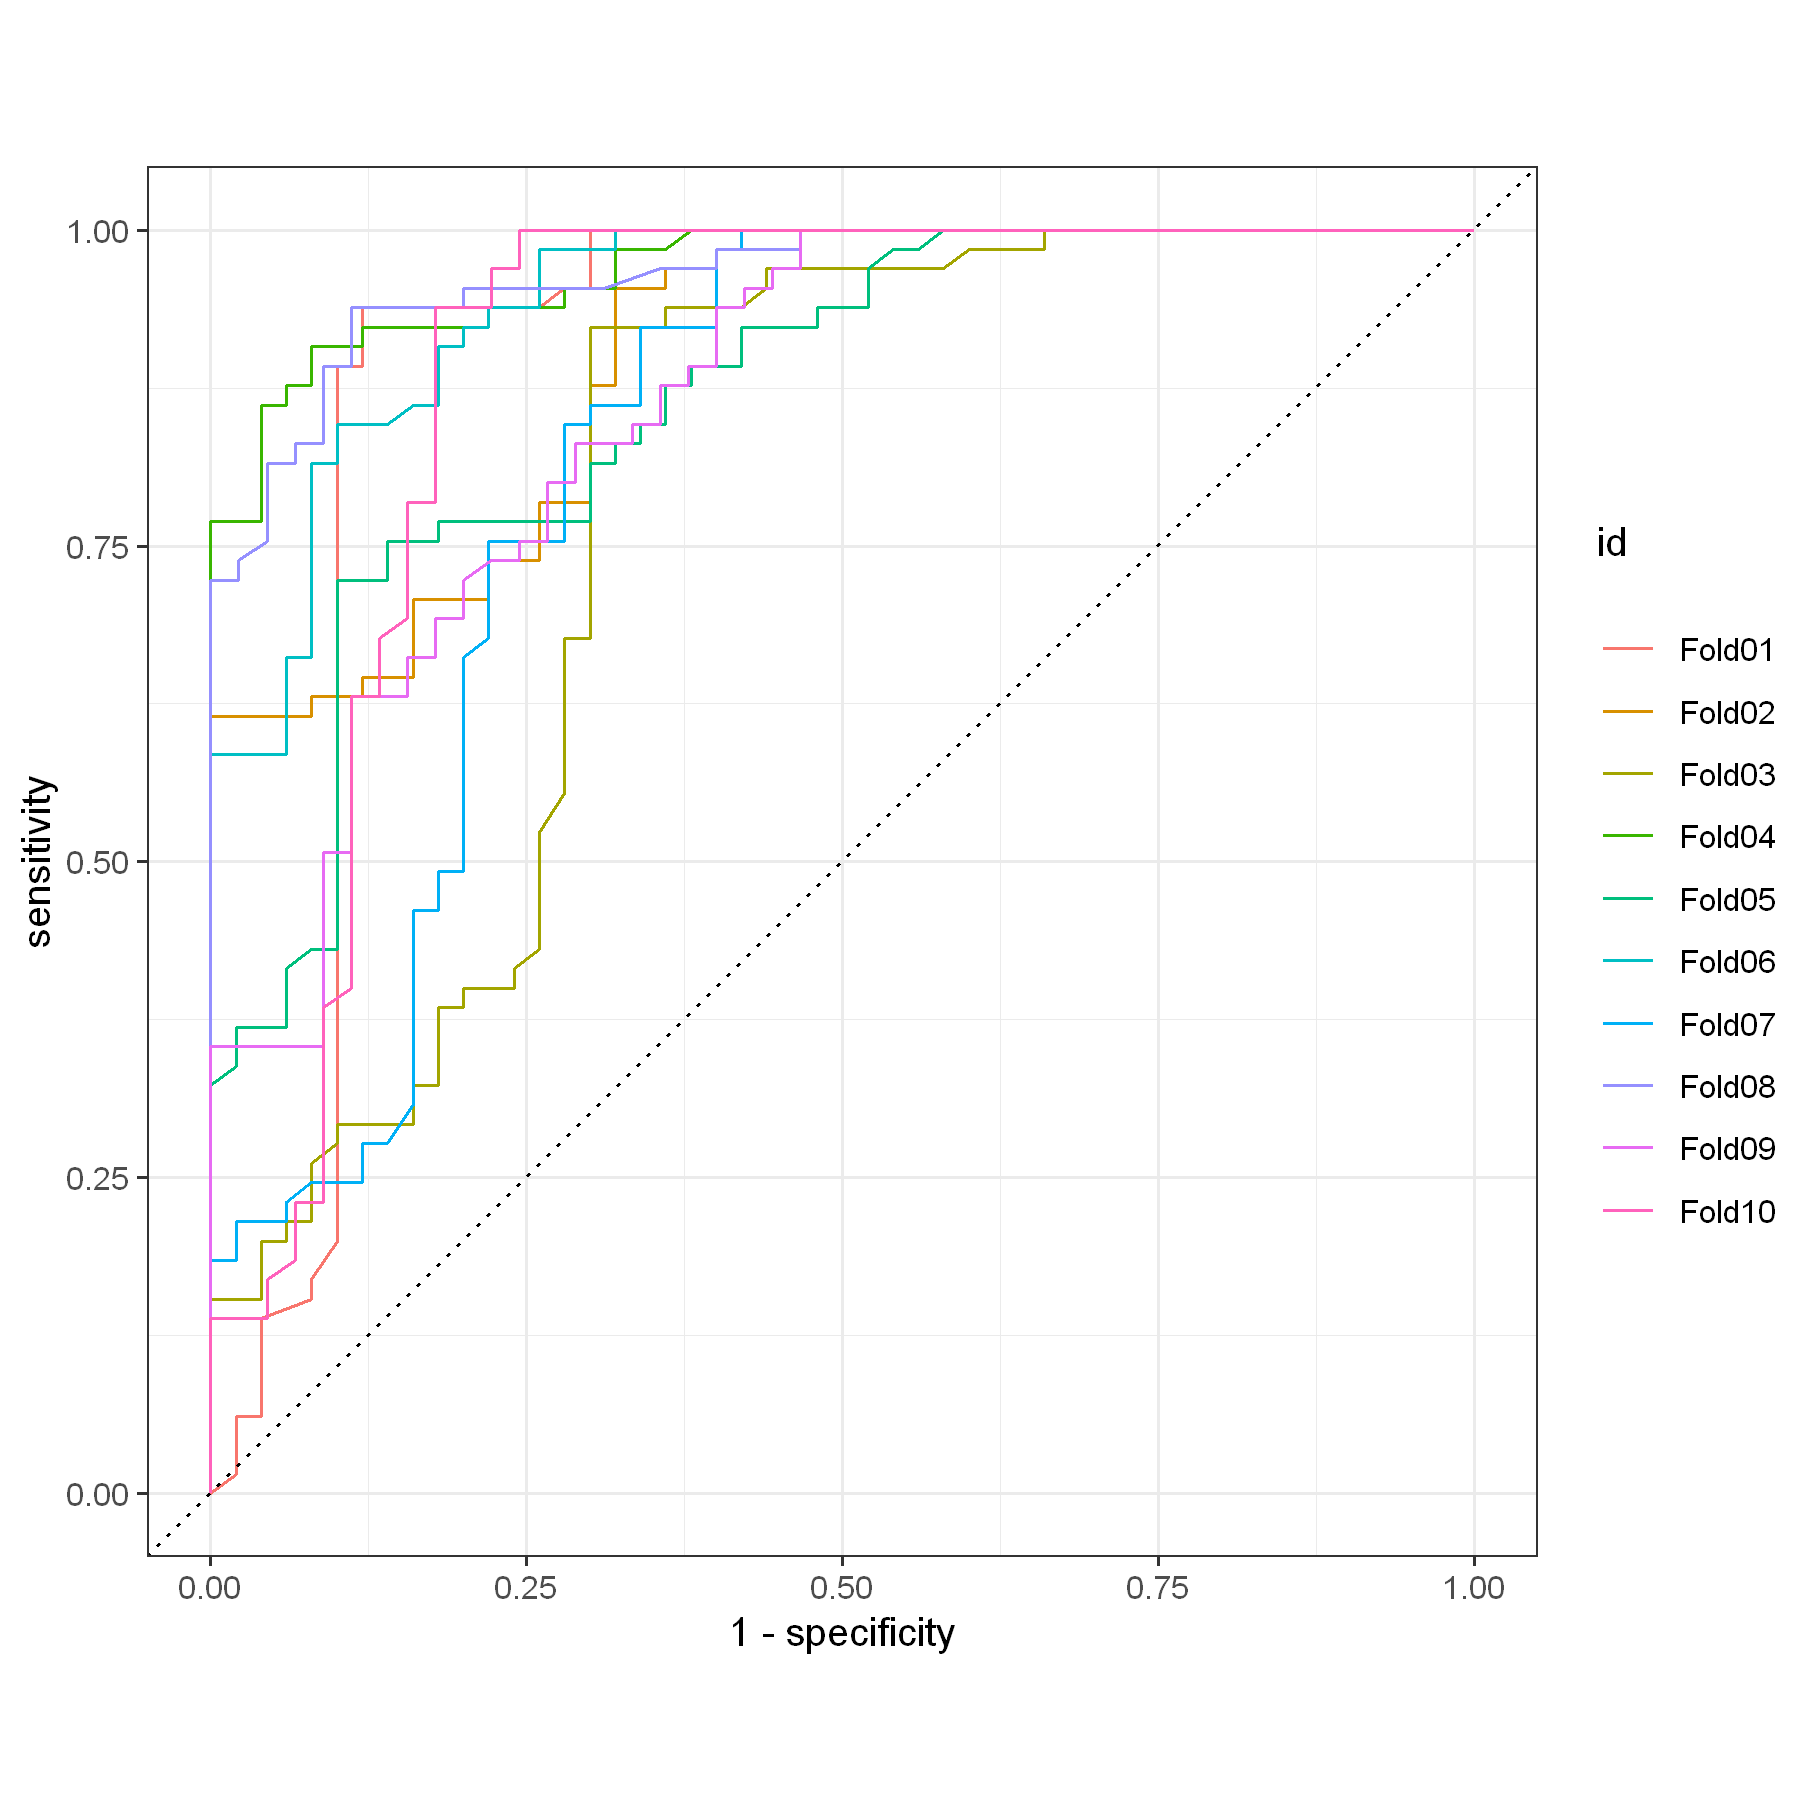

In [21]:
collect_predictions(model_results) %>%
    group_by(id) %>%
    roc_curve(heart_attack, .pred_Y) %>%
    autoplot()

In [22]:
best_rf <- select_best(model_results, metric = "accuracy")

final_results <- rf_workflow %>%
    finalize_workflow(best_rf) %>%
    last_fit(data_split)

final_fitted_wf <- final_results$.workflow[[1]]

In [23]:
final_fitted_wf

== Workflow [trained] ==================================================================================================
Preprocessor: Recipe
Model: rand_forest()

-- Preprocessor --------------------------------------------------------------------------------------------------------
3 Recipe Steps

* step_center()
* step_scale()
* step_dummy()

-- Model ---------------------------------------------------------------------------------------------------------------

Call:
 randomForest(x = maybe_data_frame(x), y = y, ntree = ~500, mtry = min_cols(~2L,      x), nodesize = min_rows(~34L, x)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 14.54%
Confusion matrix:
    Y  N class.error
Y 118 12  0.09230769
N  21 76  0.21649485

In [24]:
collect_metrics(final_results)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7763158,Preprocessor1_Model1
roc_auc,binary,0.9041812,Preprocessor1_Model1


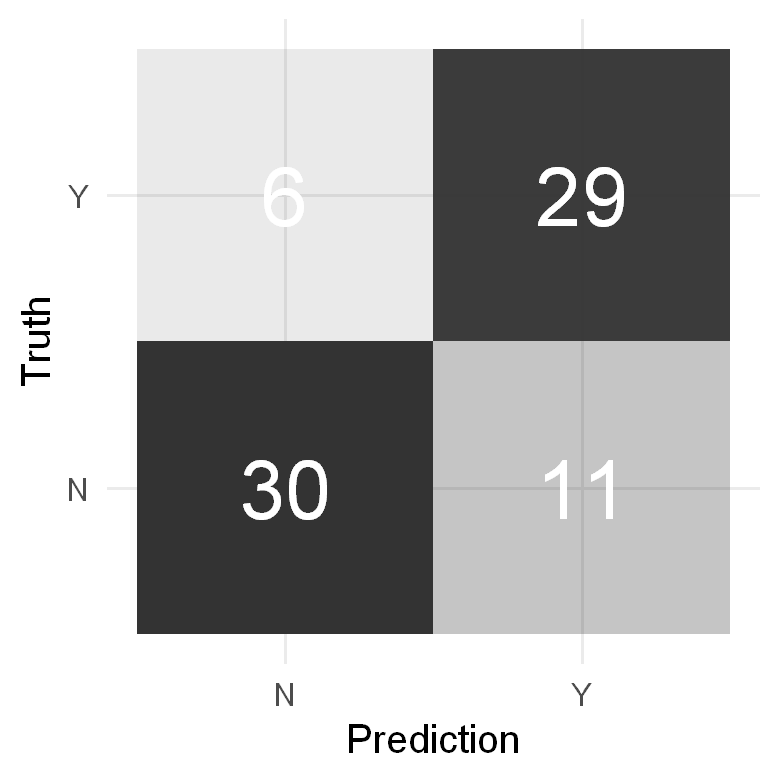

In [25]:
confusion_mat <- predict(final_fitted_wf, data_test) %>%
    bind_cols(data_test %>% select(heart_attack)) %>%
    conf_mat(heart_attack, .pred_class)

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=260)
confusion_mat %>%
    pluck(1) %>%
    as_tibble() %>%
    ggplot(aes(Prediction, Truth, alpha = n)) +
    geom_tile(show.legend = FALSE) +
    geom_text(aes(label = n), colour = "white", alpha = 1, size = 8) + 
    theme_minimal()